> ### EEE4423: Deep Learning Lab

# LAB \#14: CycleGAN

<h4><div style="text-align: right"> Due date: JUNE 10, 2022.  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab14.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2017142136] [이관희]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-06-03 11:40:55.955738


## 1. Implementation for CycleGAN
>
>
> <img src="https://drive.google.com/uc?id=1v8LUzqE7qjQnN_HtuO4bP9hogq2FVyyp" alt="no_image" style="width: 800px;"/><br>
>
> * Cycle GAN leverages a cycle consistency in image-to-image translation
> * Unlike a conditional GAN, the cycle GAN considers <U>unpaired training data</U>
>
> **1. Dataset**
>
>   * MNIST dataset
>   * SVHN dataset
>   * Note that the MNIST data is gray, where the number of the channel is 1
>
> **2. Network architecture**
>
>   * **Overall architecture**
>
> <img src="https://drive.google.com/uc?id=1YExtjmpAu57bPkgh6OqEHyMDNj7Wy7Gk" alt="no_image" style="width: 600px;"/><br>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [3])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_{in}+n_{out}}$
>       * Use <code>nn.init.xavier_uniform_</code> for the Xavier initialization
>
>     * The generative model has three components:
>       1. Encoder: 
>         * Convolutional network for feature extracting
>         * 2 convolutional layers and 2 LeakyReLU activations
>         * The output channel sizes are 64, 128 respectively<br>
>         * The kernel size of the convolutional layers are 7 and 3, respectively<br>
>            (You can use different sizes whatever you want, but we recommend those sizes)
>         * All the strides are 2
>         * Use batch normalization except for the first layer
>
>       2. Transformer: 
>         * Learn how it would like to transform the feature vector of and image from A to B. <br> 
>         * Use the resnet blok which contains the skip-connetction between the input and output for transformation<br>
>            (Please refer to <U>He et al.</U>[3])
>         * 3 resnet block layers and each of layer is followed by LeakyReLU activation
>         * All the output channel sizes are 128
>         * All the kernel sizes and strides are 3 and 1, respectively
>      
>       3. Decoder: 
>         * Upconvolutional network for reconstructing an image
>         * 2 upconvolutional layers, one LeakyReLU activations, and one Tanh activation which is for the last layer
>         * The output channel sizes are 128, 64, and 3, respectively for the SVHN data, and 128, 64, and 1, respectively for the MNIST data <br>
>         * All the kernel sizes and strides are 4 and 2, respectively
>         * Use batch normalization except for the last layers
>
>
>
> <img src="https://drive.google.com/uc?id=15pzDH7bCworNtjaJpLPz0aH4_FMtl1Jd" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * It contains 4 convolutional layers, 3 LeakyReLU activations, and one Sigmoid activation which is for the last layer
>     * The output channel sizes are 64, 128, 256, and 1, respectively
>     * All the kernel sizes are 4 except for the last kernel size which is 1
>     * The strides from the first two layers are 2 and the rest of them are 1
>     * Use batch normalization([4]) except for the first and last layers
>
>
>
> <img src="https://drive.google.com/uc?id=1XteTcNDxYiN8CP6XKoZ37jdu1yJNMNXl" alt="no_image" style="width: 600px;"/><br>
>
>
> **3. Loss function**<br>
> (In the paper, the authors use the L2 loss for the GAN loss, but the binary cross entropy loss also works well)
>  * **Discriminative model $D_X$ and $D_Y$**
>    * The loss for $D_Y$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(y_i))+(1-l_i^{real})log(1-D_Y(y_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_Y(G_Y(x_i)))+(1-l_i^{fake})log(1-D_Y(G_Y(x_i)))$ <br>
>
>  *
>    * The loss for $D_Y$ is followed as<br>
>      * Binary cross entropy loss for the real data
>      * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(x_i))+(1-l_i^{real})log(1-D_X(x_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{fake}log(D_X(G_X(y_i)))+(1-l_i^{fake})log(1-D_X(G_X(y_i)))$ <br>
>
>    ($l_i^{real}=1, l_i^{fake}=0$) <br>
>    ($G_Y$ is the generator where $x_i$ translate to $y_i$ and vice versa)
>
>
>  * **Generative model $G_X$ and $G_Y$**<br>
>
>      * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_X(G_X(y_i)))+(1-l_i^{real})log(1-D_X(G_X(y_i))) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} l_i^{real}log(D_Y(G_Y(x_i)))+(1-l_i^{real})log(1-D_Y(G_Y(x_i))) $ <br>
>
>    ($l_i^{real}=1$)
>    
>      * The cycle loss for measuring difference between $x_i$ and $G_Y(G_X(x_i))$ and vice versa
>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_Y(G_X(y_i))-y_i \rvert\rvert_1$ <br>
>    $-{1 \over N} \sum^{N}_{i=1} \lvert\lvert G_X(G_Y(x_i))-x_i \rvert\rvert_1$

## 2. Cycle GAN with Pytorch

In [2]:
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [3]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
train_X_root = '../dataset/lab14/mnist/'
train_Y_root = '../dataset/lab14/svhn/'

# Weight save directory
vis_num = 2
save_dir = './weights/lab14/cyclegan'
if not osp.exists(save_dir):
    os.makedirs(save_dir)

# Batch size during training
bs = 64

# Size of image
img_height = 32
img_width = 32
img_size = 32
img_channel = 3

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [4]:
print('STEP 1: LOADING DATASET')

transform_1ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

transform_3ch = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_X_set = dset.MNIST(root=train_X_root,
                         train=True,
                         transform=transform_1ch,
                         download=False)
train_Y_set = dset.SVHN(root=train_Y_root,
                        split='train',
                        transform=transform_3ch,
                        download=False)
test_X_set = dset.MNIST(root=train_X_root,
                         train=False,
                         transform=transform_1ch,
                         download=False)
test_Y_set = dset.SVHN(root=train_Y_root,
                        split='test',
                        transform=transform_3ch,
                        download=False)

STEP 1: LOADING DATASET


/home/jovyan/.venv/torch1.9.0-py3.8-cuda11.1/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

train_X_loader = torch.utils.data.DataLoader(train_X_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

train_Y_loader = torch.utils.data.DataLoader(train_Y_set,
                                             batch_size=bs, 
                                             shuffle=True,
                                             drop_last=True)

test_X_loader = torch.utils.data.DataLoader(test_X_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

test_Y_loader = torch.utils.data.DataLoader(test_Y_set,
                                             batch_size=bs, 
                                             shuffle=False,
                                             drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

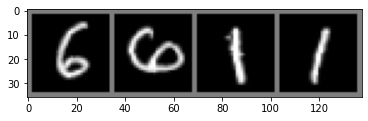

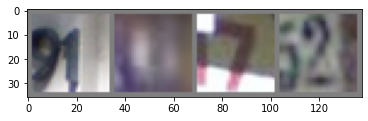

In [7]:
data_loader_X_sample = torch.utils.data.DataLoader(train_X_set,
                                                 batch_size=4, 
                                                 shuffle=True)
data_loader_Y_sample = torch.utils.data.DataLoader(train_Y_set,
                                                 batch_size=4, 
                                                 shuffle=True)

# Get a batch of training data
X = next(iter(data_loader_X_sample))
Y = next(iter(data_loader_Y_sample))

# Make a grid from batch
out_X = torchvision.utils.make_grid(X[0])
out_Y = torchvision.utils.make_grid(Y[0])

imshow(out_X)
imshow(out_Y)

### Utils 
* Use the below code for the convolution or the upconvolution

### *References*
[1] Zhu et al., "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", *ICCV*, 2017. <br>
[2] https://hardikbansal.github.io/CycleGANBlog/ <br>
[3] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010. <br>
[4] Ioffe & Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", *ICML* 2015.

In [8]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)
        
def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding,output_padding=1, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding,output_padding=1, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)
        
    if activation.lower() == 'relu':
        layers += [nn.ReLU(inplace=True)]
    if activation.lower() == 'leakyrelu':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation.lower() == 'tanh':
        layers += [nn.Tanh()]
    if activation.lower() == 'sigmoid':
        layers += [nn.Sigmoid()]
        
    return nn.Sequential(*layers)

def transpose(ndarray):
    return np.transpose(ndarray, [0,2,3,1])

def gray2rgb(ndarray):
    return np.concatenate((ndarray, ndarray, ndarray), axis=2)

### 2.1 Write the code (Generator) [3 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [56]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings]

# X : MNIST - > SHYN 

cfg_g_enc_X = [[1, gfc, 7, 1, 0, 'LeakyReLU'], [gfc, 2*gfc, 3, 2, 1, 'LeakyReLU'],[2*gfc, 4*gfc, 3, 2, 1, 'LeakyReLU']]
cfg_g_enc_Y = [[3, gfc, 7, 1, 0, 'LeakyReLU'], [gfc, 2*gfc, 3, 2, 1, 'LeakyReLU'],[2*gfc, 4*gfc, 3, 2, 1, 'LeakyReLU']]
cfg_g_dec_X = [[4*gfc, 2*gfc, 3, 2, 1, 'LeakyReLU'], [gfc*2*2, gfc, 3, 2, 1, 'LeakyReLU']]
cfg_g_dec_Y = [[4*gfc, 2*gfc, 3, 2, 1,'LeakyReLU'], [gfc*2*2, gfc, 3, 2, 1, 'LeakyReLU']]

class ResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
        )

        nn.init.xavier_uniform_(self.conv_block[1].weight)
        nn.init.xavier_uniform_(self.conv_block[5].weight)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator_X(nn.Module):
    def __init__(self):
        super(Generator_X, self).__init__()
        
        # Encoder
        self.pad = nn.ReflectionPad2d(3)
        self.conv1 = conv2d(cfg_g_enc_X[0], batch_norm=False)
        self.conv2 = conv2d(cfg_g_enc_X[1])
        self.conv3 = conv2d(cfg_g_enc_X[2])
        
        #transformer
        self.trans1 = ResidualBlock()
        self.trans2 = ResidualBlock()
        self.trans3 = ResidualBlock()
        self.trans4 = ResidualBlock()
        self.trans5 = ResidualBlock()
        self.trans6 = ResidualBlock()
        
        # Decoder
        self.deconv1 = upconv2d(cfg_g_dec_X[0])
        self.deconv2 = upconv2d(cfg_g_dec_X[1])
        self.deconv3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(2*gfc, 3, 7, 1, 0, bias=False),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
        
    def forward(self, x):
        
        x = self.pad(x)
#         print(x.size())
        output1 = self.conv1(x)
#         print(output1.size())
        #print("output1{}".format(output1.size()))  
        output2 = self.conv2(output1)
        #print("output2{}".format(output2.size()))
        output3 = self.conv3(output2)
        
        output = self.trans1(output3)
        output = self.trans2(output)
        output = self.trans3(output)
        output = self.trans4(output)
        output = self.trans5(output)
        output = self.trans6(output)

        output = self.deconv1(output)
#         print(output.size()) #13
#         print(output2.size()) #15
        dec_in = torch.cat((output, output2), dim=1)
        output = self.deconv2(dec_in)
        dec_in = torch.cat((output, output1), dim=1)
        # print(dec_in.size()) ([64, 128, 32, 32])
        output = self.deconv3(dec_in)

        return output 
    
    
class Generator_Y(nn.Module):
    def __init__(self):
        super(Generator_Y, self).__init__()
        
        # Encoder
        self.pad = nn.ReflectionPad2d(3)
        self.conv1 = conv2d(cfg_g_enc_Y[0], batch_norm=False)
        self.conv2 = conv2d(cfg_g_enc_Y[1])
        self.conv3 = conv2d(cfg_g_enc_Y[2])
        
        #transformer
        self.trans1 = ResidualBlock()
        self.trans2 = ResidualBlock()
        self.trans3 = ResidualBlock()
        self.trans4 = ResidualBlock()
        self.trans5 = ResidualBlock()
        self.trans6 = ResidualBlock()
        
        # Decoder
        self.deconv1 = upconv2d(cfg_g_dec_Y[0])
        self.deconv2 = upconv2d(cfg_g_dec_Y[1])
        self.deconv3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(2*gfc, 1, 7, 1, 0, bias=False),
            nn.BatchNorm2d(1),
            nn.Tanh()
        )
        
    def forward(self, x):
        
        x = self.pad(x)
#         print(x.size())
        output1 = self.conv1(x)
#         print(output1.size())
        #print("output1{}".format(output1.size()))  
        output2 = self.conv2(output1)
        #print("output2{}".format(output2.size()))
        output3 = self.conv3(output2)
        
        output = self.trans1(output3)
        output = self.trans2(output)
        output = self.trans3(output)
        output = self.trans4(output)
        output = self.trans5(output)
        output = self.trans6(output)

        output = self.deconv1(output)
#         print(output.size()) #13
#         print(output2.size()) #15
        dec_in = torch.cat((output, output2), dim=1)
        output = self.deconv2(dec_in) 
        dec_in = torch.cat((output, output1), dim=1)
        output = self.deconv3(dec_in) 

        return output 
        

STEP 3-1: CREATE MODEL CLASS (Generator)


### 2.2 Write the code (Discriminator) [3 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [57]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings]

cfg_d_X = [[3,gfc,4,2,1, 'LeakyReLU'], [gfc,gfc*2,4,2,1, 'LeakyReLU'], [gfc*2,gfc*4,3,1,1, 'LeakyReLU'],[gfc*4,gfc*8,3,1,1, 'LeakyReLU']]
cfg_d_Y = [[1,gfc,4,2,1, 'LeakyReLU'], [gfc,gfc*2,4,2,1, 'LeakyReLU'], [gfc*2,gfc*4,3,1,1, 'LeakyReLU'],[gfc*4,gfc*8,3,1,1, 'LeakyReLU']]


class Discriminator_X(nn.Module):
    def __init__(self):
        super(Discriminator_X, self).__init__()
        
        self.conv1 = conv2d(cfg_d_X[0], batch_norm=False)
        self.conv2 = conv2d(cfg_d_X[1])
        self.conv3 = conv2d(cfg_d_X[2])
        self.conv4 = conv2d(cfg_d_X[3])
        self.conv5 = nn.Conv2d(512,1,3,1,1)
        # self.up3 = torch.nn.Upsample(size=(32,32), mode='bilinear')
        self.sig = nn.Sigmoid()
        
        
    def forward(self, x):
#         print(x.size())
        output = self.conv1(x)
#         print(output.size())
        output = self.conv2(output)
#         print(output.size())
        output = self.conv3(output)
#         print(output.size())
        output = self.conv4(output)
#         print(output.size())
        output = self.conv5(output)
#         print(output.size())
        # output = self.up3(output)
        output = self.sig(output)
#         print(output.size())
        return output
    
    
class Discriminator_Y(nn.Module):
    def __init__(self):
        super(Discriminator_Y, self).__init__()
        self.conv1 = conv2d(cfg_d_Y[0], batch_norm=False)
        self.conv2 = conv2d(cfg_d_Y[1])
        self.conv3 = conv2d(cfg_d_Y[2])
        self.conv4 = conv2d(cfg_d_Y[3])
        self.conv5 = nn.Conv2d(512,1,3,1,1)
        # self.up3 = torch.nn.Upsample(size=(32,32), mode='bilinear')
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        output = self.conv1(x)
#         print(x.size())
        output = self.conv2(output)
#         print(output.size())
        output = self.conv3(output)
#         print(output.size())
        output = self.conv4(output)
#         print(output.size())
        output = self.conv5(output)
#         print(output.size())
        # output = self.up3(output)
        output = self.sig(output)
        return output


STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [58]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G_X = Generator_X()
model_G_Y = Generator_Y()
model_D_X = Discriminator_X()
model_D_Y = Discriminator_Y()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G_X.to(device)
print(model_G_X)
model_G_Y.to(device)
print(model_G_Y)
model_D_X.to(device)
print(model_D_X)
model_D_Y.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator_X(
  (pad): ReflectionPad2d((3, 3, 3, 3))
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (trans1): ResidualBlock(
    (conv_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Discriminator_Y(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Conv2d(512, 1, kernel_size=(3,

In [59]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G_X = torch.optim.Adam(model_G_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_Y = torch.optim.Adam(model_G_Y.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_X = torch.optim.Adam(model_D_X.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_Y = torch.optim.Adam(model_D_Y.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the Cycle GAN [4 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
it[0100/4685] 	Loss_D:0.6492 	Loss_G:6.7519 	Loss_C:0.7015 	elapsed_time:0.35mins
it[0200/4685] 	Loss_D:0.3730 	Loss_G:8.3025 	Loss_C:0.6028 	elapsed_time:0.68mins
it[0300/4685] 	Loss_D:1.0447 	Loss_G:8.5808 	Loss_C:0.5386 	elapsed_time:1.02mins
it[0400/4685] 	Loss_D:0.3673 	Loss_G:10.1455 	Loss_C:0.5319 	elapsed_time:1.37mins
it[0500/4685] 	Loss_D:0.6373 	Loss_G:11.0565 	Loss_C:0.5000 	elapsed_time:1.71mins
it[0600/4685] 	Loss_D:0.4818 	Loss_G:9.1600 	Loss_C:0.4978 	elapsed_time:2.04mins
it[0700/4685] 	Loss_D:0.2336 	Loss_G:11.0118 	Loss_C:0.4442 	elapsed_time:2.38mins
it[0800/4685] 	Loss_D:0.8505 	Loss_G:9.0241 	Loss_C:0.4238 	elapsed_time:2.73mins
it[0900/4685] 	Loss_D:0.7195 	Loss_G:5.0962 	Loss_C:0.4660 	elapsed_time:3.07mins
it[1000/4685] 	Loss_D:0.8952 	Loss_G:7.0141 	Loss_C:0.3586 	elapsed_time:3.43mins


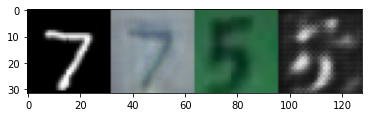

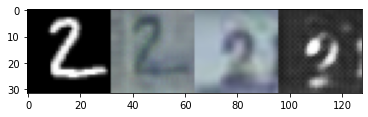

it[1100/4685] 	Loss_D:1.2549 	Loss_G:8.5964 	Loss_C:0.4080 	elapsed_time:3.81mins
it[1200/4685] 	Loss_D:0.7760 	Loss_G:5.8273 	Loss_C:0.3338 	elapsed_time:4.15mins
it[1300/4685] 	Loss_D:0.6082 	Loss_G:9.0798 	Loss_C:0.3637 	elapsed_time:4.49mins
it[1400/4685] 	Loss_D:0.8097 	Loss_G:9.1392 	Loss_C:0.3286 	elapsed_time:4.83mins
it[1500/4685] 	Loss_D:0.7938 	Loss_G:10.1763 	Loss_C:0.3199 	elapsed_time:5.17mins
it[1600/4685] 	Loss_D:0.2896 	Loss_G:10.0398 	Loss_C:0.3005 	elapsed_time:5.52mins
it[1700/4685] 	Loss_D:0.0400 	Loss_G:13.3431 	Loss_C:0.2772 	elapsed_time:5.86mins
it[1800/4685] 	Loss_D:0.1737 	Loss_G:11.7337 	Loss_C:0.3127 	elapsed_time:6.20mins
it[1900/4685] 	Loss_D:0.0847 	Loss_G:12.2594 	Loss_C:0.2695 	elapsed_time:6.55mins
it[2000/4685] 	Loss_D:0.1763 	Loss_G:12.9778 	Loss_C:0.2885 	elapsed_time:6.90mins


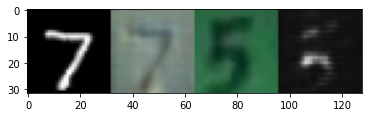

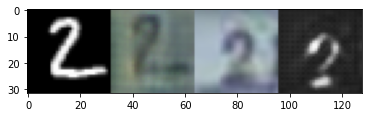

it[2100/4685] 	Loss_D:0.3140 	Loss_G:13.4820 	Loss_C:0.3011 	elapsed_time:7.28mins
it[2200/4685] 	Loss_D:0.5973 	Loss_G:12.3591 	Loss_C:0.2610 	elapsed_time:7.63mins
it[2300/4685] 	Loss_D:0.1286 	Loss_G:12.8374 	Loss_C:0.2273 	elapsed_time:7.97mins
it[2400/4685] 	Loss_D:0.3618 	Loss_G:11.5971 	Loss_C:0.2375 	elapsed_time:8.31mins
it[2500/4685] 	Loss_D:0.9760 	Loss_G:5.2251 	Loss_C:0.2409 	elapsed_time:8.65mins
it[2600/4685] 	Loss_D:0.6758 	Loss_G:6.4431 	Loss_C:0.2383 	elapsed_time:9.01mins
it[2700/4685] 	Loss_D:1.0020 	Loss_G:11.7918 	Loss_C:0.2317 	elapsed_time:9.37mins
it[2800/4685] 	Loss_D:0.7364 	Loss_G:9.8604 	Loss_C:0.2223 	elapsed_time:9.72mins
it[2900/4685] 	Loss_D:0.4641 	Loss_G:8.7752 	Loss_C:0.2218 	elapsed_time:10.08mins
it[3000/4685] 	Loss_D:1.2998 	Loss_G:6.3961 	Loss_C:0.2033 	elapsed_time:10.43mins


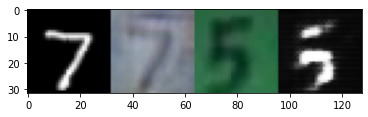

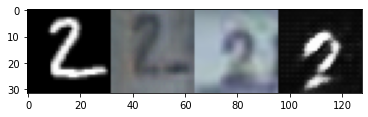

it[3100/4685] 	Loss_D:0.3696 	Loss_G:9.4762 	Loss_C:0.2104 	elapsed_time:10.82mins
it[3200/4685] 	Loss_D:0.5685 	Loss_G:10.9028 	Loss_C:0.2133 	elapsed_time:11.18mins
it[3300/4685] 	Loss_D:0.0727 	Loss_G:12.6199 	Loss_C:0.2295 	elapsed_time:11.56mins
it[3400/4685] 	Loss_D:0.3185 	Loss_G:10.4120 	Loss_C:0.1909 	elapsed_time:11.94mins
it[3500/4685] 	Loss_D:0.4460 	Loss_G:11.2225 	Loss_C:0.2035 	elapsed_time:12.33mins
it[3600/4685] 	Loss_D:0.3221 	Loss_G:11.8198 	Loss_C:0.1864 	elapsed_time:12.72mins
it[3700/4685] 	Loss_D:1.9348 	Loss_G:8.1003 	Loss_C:0.1720 	elapsed_time:13.11mins
it[3800/4685] 	Loss_D:0.6761 	Loss_G:10.2168 	Loss_C:0.1760 	elapsed_time:13.50mins
it[3900/4685] 	Loss_D:0.2519 	Loss_G:10.1310 	Loss_C:0.1722 	elapsed_time:13.89mins
it[4000/4685] 	Loss_D:0.7320 	Loss_G:10.9231 	Loss_C:0.1647 	elapsed_time:14.25mins


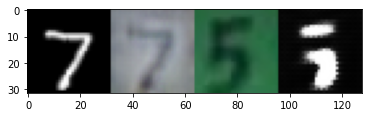

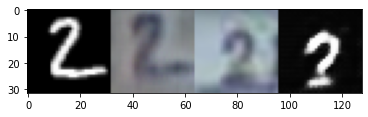

it[4100/4685] 	Loss_D:0.7907 	Loss_G:10.0587 	Loss_C:0.1942 	elapsed_time:14.66mins
it[4200/4685] 	Loss_D:0.6784 	Loss_G:10.2214 	Loss_C:0.1590 	elapsed_time:15.04mins
it[4300/4685] 	Loss_D:0.3124 	Loss_G:11.3080 	Loss_C:0.1936 	elapsed_time:15.44mins
it[4400/4685] 	Loss_D:0.4492 	Loss_G:11.3236 	Loss_C:0.1563 	elapsed_time:15.81mins
it[4500/4685] 	Loss_D:0.4893 	Loss_G:11.2220 	Loss_C:0.1541 	elapsed_time:16.20mins
it[4600/4685] 	Loss_D:0.4503 	Loss_G:10.5411 	Loss_C:0.1605 	elapsed_time:16.59mins


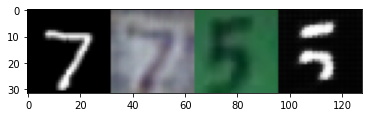

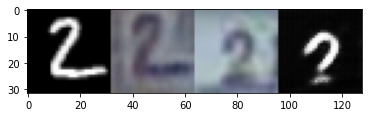

In [60]:
print('STEP 7: TRAIN THE MODEL')

# label_real = torch.full((bs, 1, 3, 3), real_label, dtype=torch.float32, device=device)
# label_fake = torch.full((bs, 1, 3, 3), fake_label, dtype=torch.float32, device=device)


label_real = torch.full((bs, 1, 8, 8), real_label, dtype=torch.float32, device=device)
label_fake = torch.full((bs, 1, 8, 8), fake_label, dtype=torch.float32, device=device)

num_iter = 0
max_iter = num_epochs*len(train_X_loader)

train_start_time = time.time()
for epoch in range(1, num_epochs+1):
    for batch_index, data_X in enumerate(train_X_loader):
        model_G_X.train()
        model_G_Y.train()
        model_D_X.train()
        model_D_Y.train()
        
        data_X = data_X[0].to(device)
        data_Y = next(iter(train_Y_loader))[0].to(device)
        
        #print(data_X.size()) # torch.Size([64, 1, 32, 32])
        #print(data_Y.size()) # torch.Size([64, 3, 32, 32])
        #print(data_Y)
        
        # G_X 가 컬러만드는 것 
        # G_Y가 MNIST 만드는 것
        
        # D_X 컬러 인풋
        # D_Y MNIST 인풋 
        
        ### Update discriminator model
        model_D_X.zero_grad()
        model_D_Y.zero_grad()
        
        output_D_X_real = model_D_X(data_Y) # 판단
        err_D_X_real = criterion_GAN(output_D_X_real, label_real)
#         print(data_X.size())
        fake_Y = model_G_X(data_X)
        output_D_X_fake = model_D_X(fake_Y.detach())
        err_D_X_fake = criterion_GAN(output_D_X_fake, label_fake)
        
#         err_D_X = err_D_X_real + err_D_X_fake
        
#         err_D_X.backward()
        
        output_D_Y_real = model_D_Y(data_X)
        err_D_Y_real = criterion_GAN(output_D_Y_real, label_real)
        fake_X = model_G_Y(data_Y)
        output_D_Y_fake = model_D_Y(fake_X.detach())
        err_D_Y_fake = criterion_GAN(output_D_Y_fake, label_fake)
        
#         err_D_Y = err_D_Y_real + err_D_Y_fake
        
#         err_D_Y.backward()
        
        err_D = err_D_X_real + err_D_X_fake + err_D_Y_real + err_D_Y_fake
        err_D.backward()
        optimizer_D_X.step()
        optimizer_D_Y.step()
        
        model_G_X.zero_grad()
        model_G_X.zero_grad()

        ### Update generator model
#         print(fake_Y.size())
        output_G_X_real = model_D_X(model_G_X(data_X))
        err_G_X = criterion_GAN(output_G_X_real, label_real)
        err_C_X = criterion_L1(model_G_Y(model_G_X(data_X)), data_X)
        
        output_G_Y_real = model_D_Y(model_G_Y(data_Y))
        err_G_Y = criterion_GAN(output_G_Y_real, label_real)
        err_C_Y = criterion_L1(model_G_X(model_G_Y(data_Y)), data_Y)
        
        err_G = err_G_X + err_G_Y
        err_C = err_C_X + err_C_Y
        
        err = err_G+100*err_C
        err.backward()

        
        optimizer_G_X.step()
        optimizer_G_Y.step()
        
        num_iter += 1
        # Output training stats
        if num_iter%100 == 0:
#         if num_iter%10 == 0:
            print('it[{:04d}/{:04d}] \tLoss_D:{:.4f} \tLoss_G:{:.4f} \tLoss_C:{:.4f} \telapsed_time:{:.2f}mins'.format(
                num_iter, max_iter, err_D.item(), err_G.item(), err_C.item(), (time.time()-train_start_time)/60 
            ))

        if num_iter%1000==0 or num_iter==max_iter:
#         if num_iter%10==0 or num_iter==max_iter:
            save_name = osp.join(save_dir, 'it{:04d}.pt'.format(num_iter))
            torch.save({
                'model_G_X': model_G_X.state_dict(),
                'model_G_Y': model_G_Y.state_dict()
            }, save_name)
    
            with torch.no_grad():
                model_G_X.eval()
                model_G_Y.eval()
                for test_index, data_X in enumerate(test_X_loader):
                    if test_index == 0:
                        
                        data_X = data_X[0].to(device)
                        data_Y = next(iter(test_Y_loader))[0].to(device)

                        output_X = model_G_X(data_X)
                        output_Y = model_G_Y(data_Y)
                        
                        data_X = ((data_X+1)/2).cpu().data.numpy()
                        data_Y = ((data_Y+1)/2).cpu().data.numpy()

                        output_X = ((output_X + 1)/2).cpu().data.numpy()
                        output_Y = ((output_Y + 1)/2).cpu().data.numpy()
                
                        for vis_idx in range(vis_num):
                            data_X_, data_Y_ = gray2rgb(transpose(data_X)[vis_idx]), transpose(data_Y)[vis_idx]
                            output_X_, output_Y_  = transpose(output_X)[vis_idx], gray2rgb(transpose(output_Y)[vis_idx])
                            outputs = np.concatenate((data_X_, output_X_, data_Y_, output_Y_), axis=1)
                            plt.imshow(outputs)
                            plt.pause(0.001)

cycleGAN 논문에서는 Generator model을 두 개의 model인 discriminator과 generator을 사용해서 구현한 GAN을 모티브로 domain을 이동하는 방향으로 학습한다. 자세히 설명하자면 Pix2Pix를 먼저 알 필요가 있다. PiX2PiX의 경우에는 paired data를 가지고 학습한 것이라면 지금 하고자 하는 것은 paired dataset을 만들 수 없거나 혹은 비용이 너무 비싸 작업하기 어려운 task에 경우에 단지 unpaired data를 가지고 input content를 유지하며 domain만을 바꾸는 학습을 진행하는 것을 목표로 한다. 이를 위해서 Generator이 2개가 필요한데 하나는 X domain에서 Y domain으로 가는 것이 필요하고 다른 하나는 Y domain에서 X domain으로 가는 것이 필요하다. 이 두개는 역함수의 관계가 있고 이렇게 두개를 연속으로 통과시킨 F(G(X))가 X가 유사해지도록 loss term(cylce)을 더해 학습을 진행한다.

예상했던 점 : GAN을 응용한 동시에 unparid data에서도 학습 가능한 cycleGAN의 경우에 꽤 그럴사한 이미지를 만들 수 있을 것이라고 사료된다.

예상과 달랐던 점 및 개선할 점 :코드를 짤 때 생각보다 u-net 구조를 삽입하는 방법이 까다로웠는데 interporation, 혹은 padding 혹은 아예 통과하는 형태가 동일하도록 설계하는 방법 등이 있었는데 그 중에서도 학습을 할 때 가장 빠른 것은 통과하는 형태가 동일하게 만들고 cat을 해주는 경우였다. 개선할 점은 위의 결과를 보면 알 수 있듯이 매우 rough한 결과를 얻었다는 것을 확인할 수 있다. 그 이유는 여러가지가 있을 테지만 mnist data로 변환하는 경우에는 글자가 있는 부분만을 1로 아닌 배경을 0으로 처리하도록 학습해야 숫자가 일정하게 색낄되어 있도록 결과가 나올텐데 그렇지 못했다는 것이 개선할 수 있는 점으로 볼 수 있다.

결론 : 결론적으로 학습을 돌리고 그에 대한 결과를 살펴보았다. cycle GAN의 경우 학습을 돌릴 코드 구현이 매우 까다롭게 느껴졌는데 그 이유는 loss를 어떻게 짜더라도 마음처럼 좋은 결과가 나오지 않았다. 그럼에도 나름 content는 유지한 결과를 살펴볼 수 있다는 것에 만족한다.

의문점 : GAN이 학습시켜도 좋은 이미지를 뱉어내기 어렵다는 한계가 있는데 이 한계를 어떻게 극복 하는가가 중요한 문제가 될 것이다. cycle GAN이후 나온 star GAN은 어떤 방법을 사용했는지 궁금하다. 